In [1]:
library(tidyverse) # readr, ggplot, dplyr, ...
library(gridExtra) # Arrangning ggplots
library(readxl)    # Loading excel
library(repr)      # Resizing the plots in jupyter
library(rugarch)   # For ARCH and GARCH models
library(dynlm)     # Lagged linear models
library(urca)      # Dick Fuller test
library(car)       # Linear hyphothesis testing
library(tseries)   # adf-test
library(vars)      # VAR models
library(zoo)       # Convert quarters to date
library(forecast)  

options(repr.plot.width=8, repr.plot.height=2)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.7
v tidyr   0.8.2     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: parallel

Attaching package: 'rugarch'

The following object is masked from 'package:purrr':

    reduce

The following object is masked from 'package:stats':

    sigma

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: carData

Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

The following object is masked from 'package:purrr'

# 1. Different forms of intervention variables

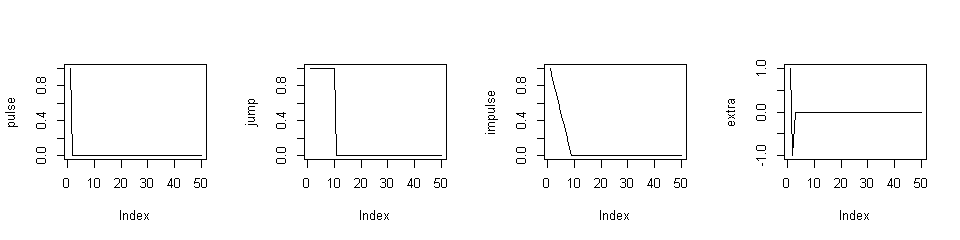

In [138]:
pulse <- rep(0,50)
pulse[1] <- 1

jump <- c(rep(1,10),rep(0,40))

impulse <- c(seq(1,0,-0.125),rep(0,41))

extra <- pulse
extra[2] <- -1

par(mfrow=c(1,4))
plot(pulse, type="l"); plot(jump, type="l"); plot(impulse, type="l"); plot(extra, type="l")

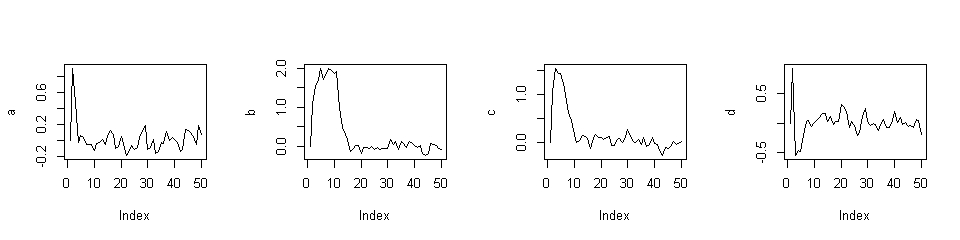

In [174]:
a <- c(0); b <- c(0); c <- c(0); d <- c(0)
for (i in 2:50) {
    a[i] <- 0.5*a[i-1] + pulse[i-1] + 0.1*rnorm(1)
    b[i] <- 0.5*b[i-1] + jump[i-1] + 0.1*rnorm(1)
    c[i] <- 0.5*c[i-1] + impulse[i-1] + 0.1*rnorm(1)
    d[i] <- 0.5*d[i-1] + extra[i-1] + 0.1*rnorm(1)
}
par(mfrow=c(1,4))
plot(a, type="l"); plot(b, type="l"); plot(c, type="l"); plot(d, type="l")

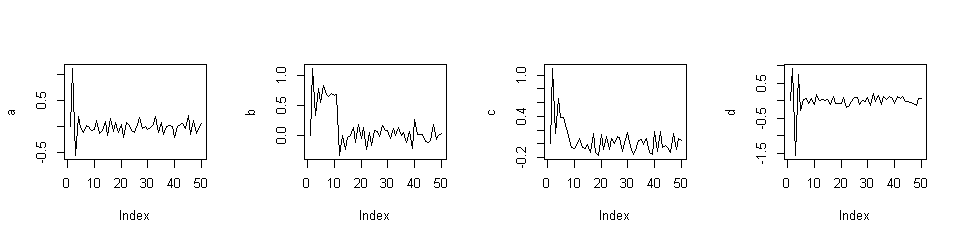

In [178]:
a <- c(0); b <- c(0); c <- c(0); d <- c(0)
for (i in 2:50) {
    a[i] <- -0.5*a[i-1] + pulse[i-1] + 0.1*rnorm(1)
    b[i] <- -0.5*b[i-1] + jump[i-1] + 0.1*rnorm(1)
    c[i] <- -0.5*c[i-1] + impulse[i-1] + 0.1*rnorm(1)
    d[i] <- -0.5*d[i-1] + extra[i-1] + 0.1*rnorm(1)
}
par(mfrow=c(1,4))
plot(a, type="l"); plot(b, type="l"); plot(c, type="l"); plot(d, type="l")

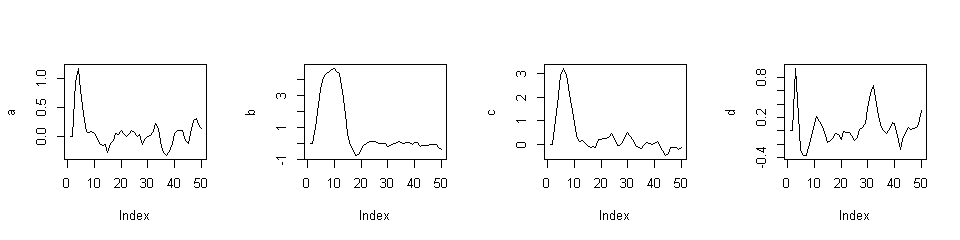

In [181]:
a <- c(0,0); b <- c(0,0); c <- c(0,0); d <- c(0,0)
for (i in 3:50) {
    a[i] <- 1.25*a[i-1] -0.5*a[i-2] + pulse[i-2] + 0.1*rnorm(1)
    b[i] <- 1.25*b[i-1] -0.5*b[i-2] + jump[i-2] + 0.1*rnorm(1)
    c[i] <- 1.25*c[i-1] -0.5*c[i-2] + impulse[i-2] + 0.1*rnorm(1)
    d[i] <- 1.25*d[i-1] -0.5*d[i-2] + extra[i-2] + 0.1*rnorm(1)
}
par(mfrow=c(1,4))
plot(a, type="l"); plot(b, type="l"); plot(c, type="l"); plot(d, type="l")

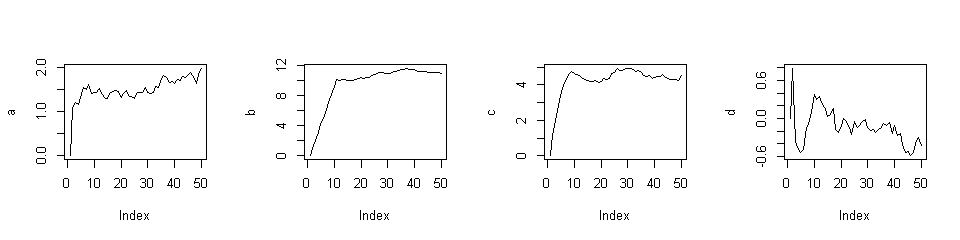

In [145]:
a <- c(0); b <- c(0); c <- c(0); d <- c(0)
for (i in 2:50) {
    a[i] <- a[i-1] + pulse[i-1] + 0.1*rnorm(1)
    b[i] <- b[i-1] + jump[i-1] + 0.1*rnorm(1)
    c[i] <- c[i-1] + impulse[i-1] + 0.1*rnorm(1)
    d[i] <- d[i-1] + extra[i-1] + 0.1*rnorm(1)
}
par(mfrow=c(1,4))
plot(a, type="l"); plot(b, type="l"); plot(c, type="l"); plot(d, type="l")

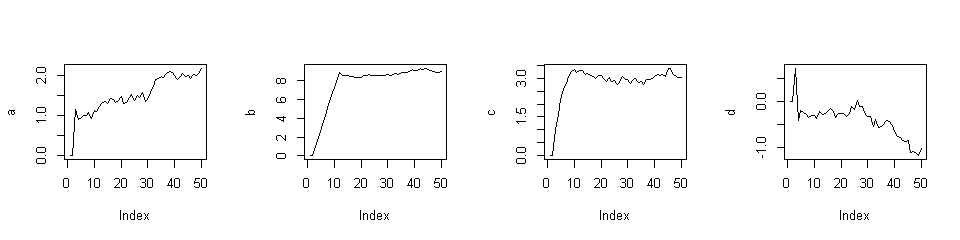

In [157]:
a <- c(0,0); b <- c(0,0); c <- c(0,0); d <- c(0,0)
for (i in 3:50) {
    a[i] <- 0.75*a[i-1] + 0.25*a[i-2] + pulse[i-2] + 0.1*rnorm(1)
    b[i] <- 0.75*b[i-1] + 0.25*b[i-2] + jump[i-2] + 0.1*rnorm(1)
    c[i] <- 0.75*c[i-1] + 0.25*c[i-2] + impulse[i-2] + 0.1*rnorm(1)
    d[i] <- 0.75*d[i-1] + 0.25*d[i-2] + extra[i-2] + 0.1*rnorm(1)
}
par(mfrow=c(1,4))
plot(a, type="l"); plot(b, type="l"); plot(c, type="l"); plot(d, type="l")

# 6. Impulse Response function

$$
\begin{bmatrix} y_t \\ z_t \end{bmatrix}
=
\begin{bmatrix} 0.8 & 0.2 \\ 0.2 & 0.8 \end{bmatrix}
\cdot
\begin{bmatrix} y_{t-1} \\ z_{t-1} \end{bmatrix}
+
\begin{bmatrix} e_{1t} \\ e_{2t} \end{bmatrix}
$$

A: Is it stationary?

In [278]:
ma <- matrix(c(0.7, 0.2,
               0.2, 0.7), nrow=2, byrow=T)
print(Mod(eigen(ma)$values))

[1] 0.9 0.5


B: Shape of impulse response function

I simulate 3 different models, one base with no simultaneous effects, and two with different choleski decomposition ordering, this makes different results for the irf function

In [5]:
yt <- c(0)
zt <- c(0)
nsim <- 2000

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + ey
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + ez
}

base1 <- irf(VAR(cbind(zt, yt), p = 1, type = "const"), n.ahead=50)$irf$zt[,2]
base2 <- irf(VAR(cbind(zt, yt), p = 1, type = "const"), n.ahead=50)$irf$yt[,1]

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + ey + 0.8*ez
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + ez
}

first1 <- irf(VAR(cbind(zt, yt), p = 1, type = "const"), n.ahead=50)$irf$zt[,2]
first2 <- irf(VAR(cbind(zt, yt), p = 1, type = "const"), n.ahead=50)$irf$yt[,1]

for (i in 2:nsim) {
    ey <- rnorm(1) 
    ez <- rnorm(1)
    yt[i] <- 0.7*yt[i-1] + 0.2*zt[i-1] + ey
    zt[i] <- 0.7*zt[i-1] + 0.2*yt[i-1] + ez + 0.8*ey
}

second1 <- irf(VAR(cbind(zt, yt), p = 1, type = "const"), n.ahead=50)$irf$zt[,2]
second2 <- irf(VAR(cbind(zt, yt), p = 1, type = "const"), n.ahead=50)$irf$yt[,1]

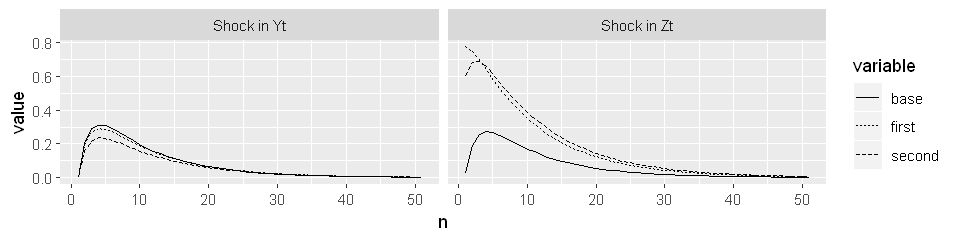

In [6]:
a <- as.data.frame(cbind(base1, first1, second1))
a$n <- c(1:51)
a <- gather(a, variable, value, -n)
a$type <- "Shock in Zt"

b <- as.data.frame(cbind(base2, first2, second2))
b$n <- c(1:51)
b <- gather(b, variable, value, -n)
b$type <- "Shock in Yt"
df <- rbind(a,b)

df$variable = substr(df$variable,1,nchar(df$variable)-1)

ggplot(df, aes(n, value, linetype=variable)) + 
geom_line() + 
facet_wrap(~type)